In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.scale import scale_factory

from dataloader import load_raw, create_datasets, create_dataloaders
from measures import quantile_loss, compute_intermittent_indicators, rho_risk

from gluonts.torch.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.torch.distributions import NegativeBinomialOutput, TweedieOutput, ZeroInflatedNegativeBinomialOutput
from gluonts.dataset.common import ListDataset
from lightning.pytorch.callbacks import EarlyStopping
from gluonts.evaluation import make_evaluation_predictions

In [22]:
dataset_name = "carparts"
method = "DNNs_new"
likelihood = 'zinb'

data_raw, data_info = load_raw(dataset_name, datasets_folder_path=os.path.join("..","data"))
adi, cv2 = compute_intermittent_indicators(data_raw, data_info['h'])
datasets = create_datasets(data_raw, data_info)

max_lag = {
    'carparts':44,
    'OnlineRetail':56,
    'Auto':16,
    'RAF':45,
    'M5':50
}
max_value = data_raw.dropna().values.max()

lags = np.arange(1,max_lag[dataset_name]) if dataset_name != "M5" else [1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,80,100,150]
lags = np.unique(np.sort(np.concatenate([lags, np.array([data_info['h']*data_info['w']])])))
quantiles = np.array([0.5, 0.8, 0.9, 0.95, 0.99])

In [23]:
def prepare_entry(x, i, scale=True):
    x.pop('feat_static_cat', None)
    x.pop('feat_dynamic_real', None)
    x.pop('item_id', None)
    x['target'] = np.array(x['target'])
    return x
    
ds_train = ListDataset([prepare_entry(x, i) for i, x in enumerate(datasets['train'])], freq=data_info['freq'])
ds_valid = ListDataset([prepare_entry(x, i) for i, x in enumerate(datasets['valid'])], freq=data_info['freq'])
ds_test = ListDataset([prepare_entry(x, i, scale=False) for i, x in enumerate(datasets['test'])], freq=data_info['freq'])

/Users/stefano.damato/Codebase/iTS/packages/gluon-ts/src/gluonts/dataset/common.py:254: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ProcessDataEntry(to_offset(freq), one_dim_target, use_timestamp),


In [3]:
from gluonts.torch.model.simple_feedforward import SimpleFeedForwardModel

?SimpleFeedForwardModel

Init signature:
SimpleFeedForwardModel(
    scale: bool,
    prediction_length: int,
    context_length: int,
    hidden_dimensions: Optional[List[int]] = None,
    distr_output: gluonts.torch.distributions.output.Output = gluonts.torch.distributions.studentT.StudentTOutput(beta=0.0),
    batch_norm: bool = False,
) -> None
Docstring:     
Module implementing a feed-forward model for forecasting.

Parameters
----------
prediction_length
    Number of time points to predict.
context_length
    Number of time steps prior to prediction time that the model.
hidden_dimensions
    Size of hidden layers in the feed-forward network.
distr_output
    Distribution to use to evaluate observations and sample predictions.
    Default: ``StudentTOutput()``.
batch_norm
    Whether to apply batch normalization. Default: ``False``.
Init docstring: Initialize internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/Codebase/iTS/packages/gluon-ts/src/gluonts/torch/model/simple_

In [8]:
if likelihood == "tw":
    distr_output = TweedieOutput()
elif likelihood == "nb":
    distr_output = NegativeBinomialOutput()
elif likelihood == "zinb":
    distr_output = ZeroInflatedNegativeBinomialOutput()
    

for lag in lags:
    print(lag)
    model_folder_name = method+"l" + str(lag) + "_" + likelihood + "__" + dataset_name
    model_folder_path = os.path.join('dnn-regression', model_folder_name)
    
    estimator = SimpleFeedForwardEstimator(
        scale=True,
        prediction_length=data_info["h"],
        context_length=lag,
        hidden_dimensions= [32, 32, 32, 32, 32],
        lr= 1e-4,
        weight_decay= 1e-8,
        distr_output=distr_output,
        batch_norm=False,
        batch_size=64,
        num_batches_per_epoch=50,
        trainer_kwargs={'accelerator':'cpu', 'max_epochs':1_000, 'enable_progress_bar': False, 'gradient_clip_val':1.0,
                        'callbacks': [EarlyStopping(monitor="val_loss", patience=20, verbose=True, mode="min")]},
    )
    
    predictor = estimator.train(training_data=ds_train, validation_data=ds_valid)
    
    forecast_it, ts_it = make_evaluation_predictions(dataset=ds_test, predictor=predictor, num_samples=400)
    forecasts, tss = list(forecast_it), list(ts_it)
    actuals = np.array([x[-data_info["h"]:].values.reshape(-1) for x in tss])
    quantile_forecasts = np.empty(shape=(len(datasets['test']), quantiles.size, data_info['h']))
    for i, f in enumerate(forecasts):
        try:
            for qi, q in enumerate(quantiles):
                quantile_forecasts[i,qi,:] = np.round(f.quantile(q))
        except:
            samples = f.to_sample_forecast(50000).samples
            quantile_forecasts[i,:,:] = np.round(np.quantile(samples, quantiles, axis=0))
            
    #quantile_forecasts[quantile_forecasts > max_value] = max_value
    
    if not os.path.exists(path=model_folder_path):
        os.makedirs(model_folder_path)
    if lag==1: np.save(os.path.join(model_folder_path,"actuals.npy"), actuals)
    np.save(os.path.join(model_folder_path,"qforecasts.npy"), quantile_forecasts)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/stefano.damato/anaconda3/envs/iTS/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/stefano.damato/anaconda3/envs/iTS/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | SimpleFeedForward

1


Metric val_loss improved. New best score: 2.819
Epoch 0, global step 50: 'val_loss' reached 2.81932 (best 2.81932), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_617/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 2.805
Epoch 1, global step 100: 'val_loss' reached 2.80451 (best 2.80451), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_617/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 2.779
Epoch 2, global step 150: 'val_loss' reached 2.77888 (best 2.77888), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_617/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 2.734
Epoch 3, global step 200: 'val_loss' reached 2.73422 (best 2.73422), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

2


Metric val_loss improved. New best score: 2.691
Epoch 0, global step 50: 'val_loss' reached 2.69113 (best 2.69113), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_618/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 2.674
Epoch 1, global step 100: 'val_loss' reached 2.67413 (best 2.67413), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_618/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 2.643
Epoch 2, global step 150: 'val_loss' reached 2.64286 (best 2.64286), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_618/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 2.589
Epoch 3, global step 200: 'val_loss' reached 2.58911 (best 2.58911), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

3


Metric val_loss improved. New best score: 2.639
Epoch 0, global step 50: 'val_loss' reached 2.63856 (best 2.63856), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_619/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 2.622
Epoch 1, global step 100: 'val_loss' reached 2.62172 (best 2.62172), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_619/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 2.588
Epoch 2, global step 150: 'val_loss' reached 2.58785 (best 2.58785), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_619/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 2.529
Epoch 3, global step 200: 'val_loss' reached 2.52879 (best 2.52879), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

4


Metric val_loss improved. New best score: 2.569
Epoch 0, global step 50: 'val_loss' reached 2.56931 (best 2.56931), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_620/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 2.534
Epoch 1, global step 100: 'val_loss' reached 2.53379 (best 2.53379), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_620/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 2.473
Epoch 2, global step 150: 'val_loss' reached 2.47329 (best 2.47329), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_620/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 2.405
Epoch 3, global step 200: 'val_loss' reached 2.40501 (best 2.40501), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

5


Metric val_loss improved. New best score: 2.541
Epoch 0, global step 50: 'val_loss' reached 2.54116 (best 2.54116), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_621/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 2.509
Epoch 1, global step 100: 'val_loss' reached 2.50930 (best 2.50930), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_621/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.459
Epoch 2, global step 150: 'val_loss' reached 2.45929 (best 2.45929), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_621/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 2.408
Epoch 3, global step 200: 'val_loss' reached 2.40751 (best 2.40751), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

6


Metric val_loss improved. New best score: 2.562
Epoch 0, global step 50: 'val_loss' reached 2.56202 (best 2.56202), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_622/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 2.535
Epoch 1, global step 100: 'val_loss' reached 2.53530 (best 2.53530), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_622/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 2.483
Epoch 2, global step 150: 'val_loss' reached 2.48305 (best 2.48305), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_622/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 2.404
Epoch 3, global step 200: 'val_loss' reached 2.40365 (best 2.40365), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

7


Metric val_loss improved. New best score: 2.548
Epoch 0, global step 50: 'val_loss' reached 2.54755 (best 2.54755), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_623/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 2.518
Epoch 1, global step 100: 'val_loss' reached 2.51843 (best 2.51843), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_623/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 2.466
Epoch 2, global step 150: 'val_loss' reached 2.46626 (best 2.46626), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_623/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 2.402
Epoch 3, global step 200: 'val_loss' reached 2.40204 (best 2.40204), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

8


Metric val_loss improved. New best score: 2.589
Epoch 0, global step 50: 'val_loss' reached 2.58890 (best 2.58890), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_624/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 2.545
Epoch 1, global step 100: 'val_loss' reached 2.54480 (best 2.54480), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_624/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 2.460
Epoch 2, global step 150: 'val_loss' reached 2.45995 (best 2.45995), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_624/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 2.365
Epoch 3, global step 200: 'val_loss' reached 2.36453 (best 2.36453), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

9


Metric val_loss improved. New best score: 2.543
Epoch 0, global step 50: 'val_loss' reached 2.54330 (best 2.54330), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_625/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 2.521
Epoch 1, global step 100: 'val_loss' reached 2.52141 (best 2.52141), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_625/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 2.478
Epoch 2, global step 150: 'val_loss' reached 2.47848 (best 2.47848), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_625/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 2.418
Epoch 3, global step 200: 'val_loss' reached 2.41766 (best 2.41766), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

10


Metric val_loss improved. New best score: 2.588
Epoch 0, global step 50: 'val_loss' reached 2.58799 (best 2.58799), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_626/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 2.547
Epoch 1, global step 100: 'val_loss' reached 2.54709 (best 2.54709), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_626/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 2.474
Epoch 2, global step 150: 'val_loss' reached 2.47440 (best 2.47440), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_626/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 2.400
Epoch 3, global step 200: 'val_loss' reached 2.40022 (best 2.40022), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

11


Metric val_loss improved. New best score: 2.553
Epoch 0, global step 50: 'val_loss' reached 2.55273 (best 2.55273), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_627/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 2.516
Epoch 1, global step 100: 'val_loss' reached 2.51577 (best 2.51577), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_627/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 2.453
Epoch 2, global step 150: 'val_loss' reached 2.45258 (best 2.45258), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_627/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 2.382
Epoch 3, global step 200: 'val_loss' reached 2.38196 (best 2.38196), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

12


Metric val_loss improved. New best score: 2.527
Epoch 0, global step 50: 'val_loss' reached 2.52701 (best 2.52701), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_628/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 2.496
Epoch 1, global step 100: 'val_loss' reached 2.49587 (best 2.49587), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_628/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 2.440
Epoch 2, global step 150: 'val_loss' reached 2.44015 (best 2.44015), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_628/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 2.365
Epoch 3, global step 200: 'val_loss' reached 2.36457 (best 2.36457), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

13


Metric val_loss improved. New best score: 2.558
Epoch 0, global step 50: 'val_loss' reached 2.55841 (best 2.55841), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_629/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 2.517
Epoch 1, global step 100: 'val_loss' reached 2.51681 (best 2.51681), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_629/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 2.443
Epoch 2, global step 150: 'val_loss' reached 2.44322 (best 2.44322), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_629/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 2.369
Epoch 3, global step 200: 'val_loss' reached 2.36878 (best 2.36878), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

14


Metric val_loss improved. New best score: 2.501
Epoch 0, global step 50: 'val_loss' reached 2.50052 (best 2.50052), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_630/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 2.463
Epoch 1, global step 100: 'val_loss' reached 2.46335 (best 2.46335), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_630/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 2.409
Epoch 2, global step 150: 'val_loss' reached 2.40866 (best 2.40866), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_630/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 2.405
Epoch 3, global step 200: 'val_loss' reached 2.40537 (best 2.40537), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

15


Metric val_loss improved. New best score: 2.578
Epoch 0, global step 50: 'val_loss' reached 2.57789 (best 2.57789), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_631/checkpoints/epoch=0-step=50.ckpt' as top 1
Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 2.538
Epoch 1, global step 100: 'val_loss' reached 2.53765 (best 2.53765), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_631/checkpoints/epoch=1-step=100.ckpt' as top 1
Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 2.466
Epoch 2, global step 150: 'val_loss' reached 2.46614 (best 2.46614), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_logs/version_631/checkpoints/epoch=2-step=150.ckpt' as top 1
Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 2.394
Epoch 3, global step 200: 'val_loss' reached 2.39399 (best 2.39399), saving model to '/Users/stefano.damato/Codebase/iTS/src/lightning_log

In [4]:
from gluonts.time_feature import get_lags_for_frequency

get_lags_for_frequency('M')

list(range(1, 10))

/Users/stefano.damato/Codebase/iTS/packages/gluon-ts/src/gluonts/time_feature/lag.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [24]:
subset="intermittent_and_lumpy"
if subset == "intermittent":
    filter, filter_label = np.logical_and(adi >= 1.32, cv2 < .49), "intermittent"
elif subset == "intermittent_and_lumpy":
    filter, filter_label = adi >= 1.32, "intermittent_and_lumpy"
elif subset == "all":
    filter, filter_label = np.tile(True, adi.size), "all"

In [29]:
tmp = np.empty(shape=(len(datasets['test']), len(datasets['valid'][0]['target']), quantiles.size))
for i in range(len(datasets['test'])):
    tmp[i, :] = np.round(np.quantile(datasets['valid'][i]['target'], q=quantiles))
res_base_scale_tmp = []
for i in range(len(datasets['test'])):
    res_base_scale_tmp.append(quantile_loss(
        np.array(datasets['valid'][i]['target']).reshape(1,-1), 
        tmp[i].reshape(1,tmp[i].shape[0],tmp[i].shape[1]), 
        quantiles, avg=False))
res_base_scale = {}
for q in ['QL50','QL80','QL90','QL95','QL99']:
    res_base_scale[q] = np.mean(np.vstack([res_base_scale_tmp[i][q] for i in range(len(datasets['test']))]), axis=1)

scale = True
fscale = lambda x, q: x / res_base_scale[q][filter, np.newaxis] if scale else x

path = os.path.join("dnn-regression")
names = [folder for folder in os.listdir(path) 
                  if os.path.isdir(os.path.join(path, folder))]
names_sub = [x for x in names if (x.split('__')[1] == dataset_name) and (x.split('__')[0].split('l')[0] == method)]
M = {"tw":{}, "nb":{}, 'zinb':{}}
actuals = np.load(os.path.join(path, method+'l1_nb__'+dataset_name, "actuals.npy"))[filter]
for n in names_sub:
    quantile_forecasts = np.load(os.path.join(path, n, "qforecasts.npy"))[filter]
    l, distr = n.split('l')[1].split('__')[0].split('_')
    M[distr][int(l)] = quantile_loss(actuals, np.transpose(quantile_forecasts, (0,2,1)), quantiles, avg=False)

for distr in M.keys():  
    M[distr] = {key: M[distr][key] for key in sorted(M[distr].keys())}

for distr in M.keys():
    for k in M[distr].keys():
        for l in M[distr][k].keys():
            M[distr][k][l] = fscale(M[distr][k][l], l)

# Local methods
baseline_path = os.path.join(os.path.expanduser("~/switchdrive"), "iTS", "trained_models_baselines")
baselines_name = [folder for folder in os.listdir(baseline_path) 
                  if os.path.isdir(os.path.join(baseline_path, folder)) and os.path.exists(os.path.join(baseline_path, folder, 'metrics.json'))]
baselines_name_sub = [x for x in baselines_name if x.split('__')[1] == dataset_name]

iETS_actuals = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["iETS" in x for x in baselines_name_sub]][0], "actuals.npy"))[filter]
iETS_quantile_forecasts = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["iETS" in x for x in baselines_name_sub]][0], "qforecasts.npy"))[filter]
iETS = quantile_loss(iETS_actuals, iETS_quantile_forecasts, quantiles, avg=False)
EmpQ_actuals = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["EmpQ" in x for x in baselines_name_sub]][0], "actuals.npy"))[filter]
EmpQ_quantile_forecasts = np.load(os.path.join(baseline_path, np.array(baselines_name_sub)[["EmpQ" in x for x in baselines_name_sub]][0], "qforecasts.npy"))[filter]
EmpQ = quantile_loss(EmpQ_actuals, EmpQ_quantile_forecasts, quantiles, avg=False)
Tweedie_quantile_forecasts = np.load(os.path.join(os.path.expanduser("~/switchdrive"), "iTS", "trained_models_baselines", f"TweedieGP/{dataset_name}/qforecasts.npy"))[filter]
Tweedie = quantile_loss(iETS_actuals, Tweedie_quantile_forecasts, quantiles, avg=False)

assert iETS.keys() == EmpQ.keys() == Tweedie.keys()
for k in iETS.keys():
    iETS[k] = fscale(iETS[k],k)
    EmpQ[k] = fscale(EmpQ[k],k)
    Tweedie[k] = fscale(Tweedie[k],k)

In [26]:
import pickle as pkl
for distr in M.keys():
    pkl.dump(M[distr], open(os.path.join('cache_global', method+'_'+distr+'_'+dataset_name+".pkl"), 'wb'))
pkl.dump(iETS, open(os.path.join('cache_global', "iETS"+'_'+dataset_name+".pkl"), 'wb'))
pkl.dump(EmpQ, open(os.path.join('cache_global', "EmpQ"+'_'+dataset_name+".pkl"), 'wb'))
pkl.dump(Tweedie, open(os.path.join('cache_global', "Tweedie"+'_'+dataset_name+".pkl"), 'wb'))

KeyError: 1

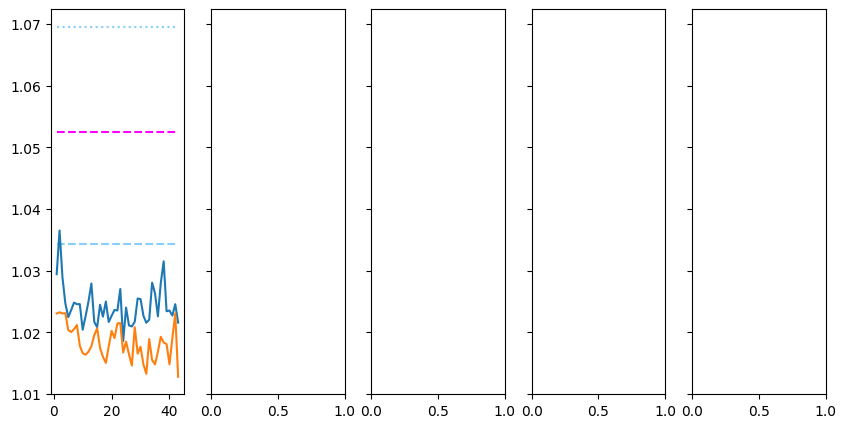

In [27]:
f = np.mean
d = ['nb', 'tw', 'zinb']

Q = list(M[d[0]][lags[0]].keys())
fig, axs = plt.subplots(1,len(Q), figsize=(10,5), sharey=True)
colors = ['#87CEFA','#00BFFF','#1E90FF','#4682B4','#191970']
for ax, c, q_ in zip(axs, colors, Q):
    ax.hlines(y=f(EmpQ[q_]), xmin=1, xmax=lags[-1], color=c, linestyle=':', label="EmpQ")
    ax.hlines(y=f(iETS[q_]), xmin=1, xmax=lags[-1], color=c, linestyle='--', label="iETS")
    ax.hlines(y=f(Tweedie[q_]), xmin=1, xmax=lags[-1], color="magenta", linestyle='--', label="TweedieGP")
    for distr in d:
        tmp = np.array([np.nanmean(M[distr][l][q_]) for l in lags])
        ax.plot(lags, tmp, label="DNN_"+distr, )
    ax.set_title(q_)
axs[2].set_xlabel('LAG')
axs[0].set_ylabel('QL')
axs[0].legend(loc="upper left")
plt.suptitle(dataset_name)
plt.tight_layout()
plt.show()

In [ ]:
import itertools

models = ['informer', 'autoformer']
dataset = ['Auto', 'carparts', 'M5', 'OnlineRetail', 'RAF']
likelihood = ['tweedie', 'negbin']
scaling = ['none', 'mean-demand']

for experiment in itertools.product(models, dataset, likelihood, scaling):
    count = 0
    experiment = list(experiment)
    for folder in os.listdir(os.path.join(os.getcwd(), os.pardir, 'trained_models')):
       if folder.split('__')[:4] == experiment:
           count += 1
    print('_'.join(experiment), '\t', count)
    



informer_Auto_tweedie_none 	 0
informer_Auto_tweedie_mean-demand 	 0
informer_Auto_negbin_none 	 0
informer_Auto_negbin_mean-demand 	 0
informer_carparts_tweedie_none 	 0
informer_carparts_tweedie_mean-demand 	 0
informer_carparts_negbin_none 	 0
informer_carparts_negbin_mean-demand 	 0
informer_M5_tweedie_none 	 0
informer_M5_tweedie_mean-demand 	 0
informer_M5_negbin_none 	 0
informer_M5_negbin_mean-demand 	 0
informer_OnlineRetail_tweedie_none 	 0
informer_OnlineRetail_tweedie_mean-demand 	 0
informer_OnlineRetail_negbin_none 	 0
informer_OnlineRetail_negbin_mean-demand 	 0
informer_RAF_tweedie_none 	 0
informer_RAF_tweedie_mean-demand 	 0
informer_RAF_negbin_none 	 0
informer_RAF_negbin_mean-demand 	 0
autoformer_Auto_tweedie_none 	 0
autoformer_Auto_tweedie_mean-demand 	 0
autoformer_Auto_negbin_none 	 3
autoformer_Auto_negbin_mean-demand 	 3
autoformer_carparts_tweedie_none 	 0
autoformer_carparts_tweedie_mean-demand 	 0
autoformer_carparts_negbin_none 	 3
autoformer_carparts_neg

In [ ]:
import itertools

exp_dict = {}

for folder in os.listdir(os.path.join(os.getcwd(), os.pardir, 'trained_models')):
    experiment = tuple(folder.split('__')[:4])
    if experiment not in exp_dict.keys():
        exp_dict[experiment] = 0
    exp_dict[experiment] += 1

for experiment in exp_dict.keys():
    print(experiment, '\t', exp_dict[experiment])
    

    

('autoformer', 'Auto', 'negbin', 'mean-demand') 	 3
('autoformer', 'M5', 'negbin', 'mean-demand') 	 2
('autoformer', 'RAF', 'negbin', 'mean-demand') 	 2
('autoformer', 'Auto', 'negbin', 'none') 	 3
('.DS_Store',) 	 1
('autoformer', 'OnlineRetail', 'negbin', 'none') 	 2
('autoformer', 'OnlineRetail', 'negbin', 'mean-demand') 	 2
('autoformer', 'carparts', 'negbin', 'mean-demand') 	 3
('autoformer', 'RAF', 'negbin', 'none') 	 2
('autoformer', 'M5', 'negbin', 'none') 	 3
('autoformer', 'carparts', 'negbin', 'none') 	 3
